# Cross-matching of large catalogs: DES to Gaia

In this tutorial we cross-match nain tables of Dark Energy Survey (DES) DR2 and Gaia DR3 catalogs. The outline of the tutorial is as follows:

1. Get original data files
2. Convert the data to HiPSCat format using [hipscat-import](https://github.com/astronomy-commons/hipscat-import/)
3. Cross-match the catalogs using LSDB and save to a new HiPSCat catalog

### Install required packages and import modules

In [ ]:
# Comment to skip hipscat-import installation
%pip install --quiet hipscat-import

# Uncomment to install lsdb
# %pip install --quiet lsdb

In [ ]:
# For files and directories manipulation
from pathlib import Path

# For Gaia columns data types inference
import pyarrow
from astropy.io import ascii

# We need this for 2D histogram
import dask.array

# Client for Dask distributed computing
from dask.distributed import Client

# For plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Numpy is always useful!
import numpy as np

# Explore the HiPSCat catalogs and plot sky maps
from hipscat.catalog import Catalog
from hipscat.inspection import plot_pixels

# For reading the HiPSCat catalogs and performing the cross-match
import lsdb

# For converting the data to HiPSCat format and generate margin caches
from hipscat_import.catalog.file_readers import CsvReader
from hipscat_import.margin_cache.margin_cache_arguments import MarginCacheArguments
from hipscat_import.pipeline import ImportArguments, pipeline_with_client

## Get original data files

To make this notebook faster to run and using less storage, we will use a subset of the data. However, the same pipeline, with no code changes, may be used to process the full catalogs.

In [ ]:
# Change to the directories where the data will be stored
DES_DIR = Path("data/DES_DR2")
GAIA_DIR = Path("data/Gaia_DR3")

GAIA_SCHEMA_FILE = GAIA_DIR / "schema.parquet"

DES_HIPSCAT_NAME = "des_dr2"
GAIA_HIPSCAT_NAME = "gaia_dr3"
GAIA_MARGIN_CACHE_NAME = "gaia_dr3_1arcsec"
XMATCH_NAME = "des_dr2_x_gaia_dr3"

HIPSCAT_DIR = Path("hipscat")
DES_HIPSCAT_DIR = HIPSCAT_DIR / DES_HIPSCAT_NAME
GAIA_HIPSCAT_DIR = HIPSCAT_DIR / GAIA_HIPSCAT_NAME
GAIA_MARGIN_CACHE_DIR = HIPSCAT_DIR / GAIA_MARGIN_CACHE_NAME

OUTPUT_HIPSCAT_DIR = HIPSCAT_DIR / XMATCH_NAME

### DES DR2

The Dark Eenrgy Survey DR2 catalog is hosted by NCSA, see the [official website](https://des.ncsa.illinois.edu/releases/dr2) for more information. Data files, in [FITS](https://fits.gsfc.nasa.gov) format, are located at <https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/>. You may also prefer to get the data with S3 client as described by <https://desdr-server.ncsa.illinois.edu>

We use `*dr2_main.fits` files for the main catalog table, see [the schema here](https://des.ncsa.illinois.edu/releases/dr2/dr2-products/dr2-schema).

Here we download a few first files to demonstrate the pipeline. The full catalog is about 1.1TB, feel free to download it if you have enough storage.

In [ ]:
# Comment / skip this cell if you already have the data

from shutil import copyfileobj

import requests  # For downloading files

# Download few first files
des_urls = [
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0209/DES0000+0209_dr2_main.fits",
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0252/DES0000+0252_dr2_main.fits",
    "https://desdr-server.ncsa.illinois.edu/despublic/dr2_tiles/DES0000+0335/DES0000+0335_dr2_main.fits",
]

for des_url in des_urls:
    des_file = DES_DIR / Path(des_url).name
    if not des_file.exists():
        des_file.parent.mkdir(parents=True, exist_ok=True)
        with requests.get(des_url, stream=True) as r, open(des_file, "wb") as f:
            copyfileobj(r.raw, f)

### Gaia DR3

The Gaia DR3 catalog is hosted by ESA, see the [official website](https://www.cosmos.esa.int/web/gaia/dr3) for more information. Data files, in [ECSV](https://docs.astropy.org/en/stable/io/ascii/ecsv.html) format are located at <http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/>.

We use `gaia_source` table, see its [schema here](https://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/sec_dm_main_source_catalogue/ssec_dm_gaia_source.html).

Here we donwload a few files which barely correspond to the same area of the sky as the DES DR2 files above. The full catalog is much larger, feel free to download it all if you have enough storage.

In [ ]:
# Comment / skip this cell if you already have the data

from shutil import copyfileobj

import requests  # For downloading files

# Download few first files
gaia_urls = [
    "http://cdn.gea.esac.esa.int/Gaia/gdr3/gaia_source/GaiaSource_310878-313367.csv.gz",
]

for gaia_url in gaia_urls:
    gaia_file = GAIA_DIR / Path(gaia_url).name
    if not gaia_file.exists():
        gaia_file.parent.mkdir(parents=True, exist_ok=True)
        with requests.get(gaia_url, stream=True) as r, open(gaia_file, "wb") as f:
            copyfileobj(r.raw, f)

## Create Dask client

Both `hipscat-import` and `lsdb` use [Dask](https://dask.org) for parallel processing. We create a Dask client here to be used in all the following pipelines steps. We destroy the client at the end of the notebook.

In [ ]:
# See Dask documentation for the options, e.g. https://distributed.dask.org/en/latest/local-cluster.html
# You would likely want to change `n_workers` to have an optimal performance while not going out of memory.
client = Client()

## Convert the data to HiPSCat format

We use the [hipscat-import](https://github.com/astronomy-commons/hipscat-import/) tool to create HiPSCat catalogs from the original data files.

### Convert DES DR2 to HiPSCat

- Plan the pipeline specifying all parameters of the conversion
- Run the pipeline with [Dask](https://dask.org)

In [ ]:
des_args = ImportArguments(
    sort_columns="COADD_OBJECT_ID",
    ra_column="RA",
    dec_column="DEC",
    input_path=DES_DIR,
    file_reader="fits",
    output_artifact_name=DES_HIPSCAT_NAME,
    output_path=HIPSCAT_DIR,
    # Uncomment to overwrite existing catalog
    # overwrite=True,
)

pipeline_with_client(des_args, client)

#### Plot the DES DR2 HiPSCat catalog pixels

In [ ]:
# Read the HiPSCat catalog metadata, it does not load any data, just healpix pixels and other metadata
des_hipscat_catalog = Catalog.read_from_hipscat(DES_HIPSCAT_DIR)
plot_pixels(des_hipscat_catalog)

# TODO: add DES footprint to this plot
# https://des.ncsa.illinois.edu/static/images/dr2/dr2_footprint.png

This is what you would get for the full catalog, it would have many healpix tiles instead of just a single one. The reason is that `hipscat-import` splits the data into multiple files to have no more than a million rows per healpix tile / HiPSCat parquet file.

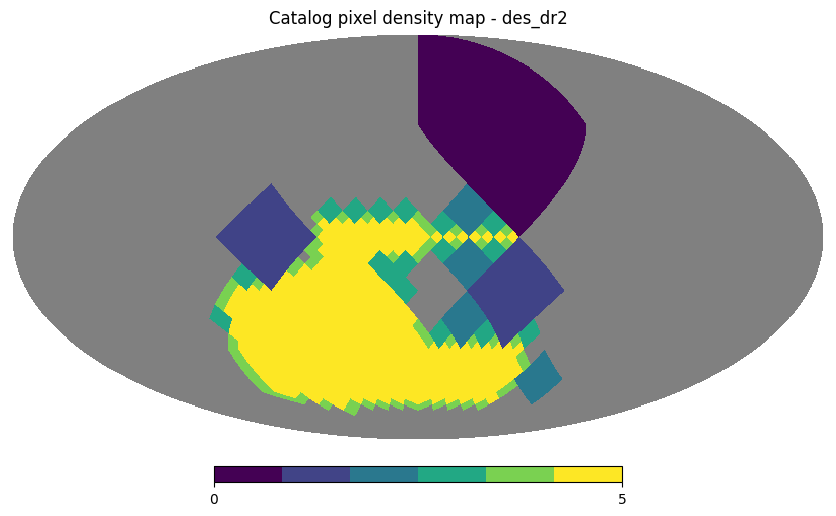

Compare it to the DES DR2 footprint:
![DES DR2 footprint](https://des.ncsa.illinois.edu/static/images/dr2/dr2_footprint.png)

### Convert Gaia DR3 to HiPSCat

For Gaia we need to specify schema of the input data, because currently `hipscat-import` cannot infer column data types properly from this dataset.

See this GitHub issue for more details: <https://github.com/astronomy-commons/hipscat-import/issues/225>

In [ ]:
gaia_file = next(GAIA_DIR.glob("*.csv.gz"))
empty_astropy_table = ascii.read(gaia_file, format="ecsv", data_end=1)
empty_astropy_table.write(
    GAIA_SCHEMA_FILE,
    # Uncomment to overwrite existing schema file
    # overwrite=True,
)

In [ ]:
gaia_args = ImportArguments(
    # sort columns are optional and works only if few objects are very close to each other
    sort_columns="source_id",
    ra_column="ra",
    dec_column="dec",
    # We select all Gaia ECSV files skipping the schema file
    input_file_list=list(GAIA_DIR.glob("*.csv.gz")),
    file_reader=CsvReader(
        comment="#",
        schema_file=GAIA_SCHEMA_FILE,
        parquet_kwargs={"dtype_backend": "pyarrow", "engine": "pyarrow"},
    ),
    use_schema_file=GAIA_SCHEMA_FILE,
    output_artifact_name=GAIA_HIPSCAT_NAME,
    output_path=HIPSCAT_DIR,
    # Uncomment to overwrite existing catalog
    # overwrite=True,
)

pipeline_with_client(gaia_args, client)

#### Plot the Gaia DR3 HiPSCat catalog pixels

In [ ]:
# It should be full sky for the whole catalog
gaia_hipscat_catalog = Catalog.read_from_hipscat(GAIA_HIPSCAT_DIR)
plot_pixels(gaia_hipscat_catalog)

And this is how it would look like for the entire Gaia catalog.
Notice how Milky Way region is denser and thus has higher healpix order (smaller tiles), since `hipscat-import` limits the maximum number of objects per pixel to be 1 million.

![Entire Gaia Sky map](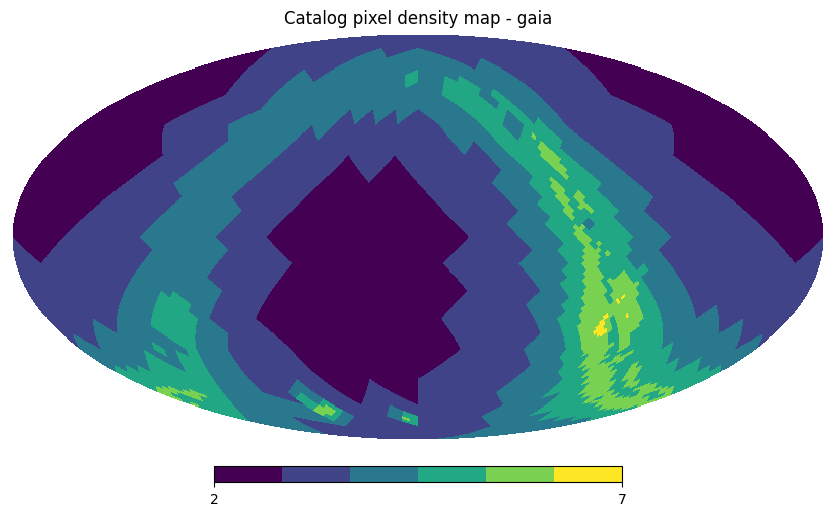
)

#### Generate matgin cache for the Gaia HiPSCat catalog

LSDB requires right-catalog margin cache to generate the complete cross-match result.
Without the margin cache, the objects located near the edges of Healpix tiles may be missed in the cross-match.

In [ ]:
margin_cache_args = MarginCacheArguments(
    input_catalog_path=GAIA_HIPSCAT_DIR,
    output_path=HIPSCAT_DIR,
    margin_threshold=1.0,  # arcsec
    output_artifact_name=GAIA_MARGIN_CACHE_NAME,
    # Uncomment to overwrite existing margin cache
    # overwrite=True,
)

pipeline_with_client(margin_cache_args, client)

### Cross-match the catalogs

The cross-matching in LSDB is not symmetric, meaning the choice of which catalog is "left" and which is "right" is crucial. In our case, we cross-match DES (left) to Gaia (right). This setup generally allows for multiple DES objects to be matched to a single Gaia object, a result of margin caches. Margin caches are designed to prevent missing objects near the edges of Healpix tiles. However, they can lead to multiple matches, where the same Gaia object might match to one DES object in its own tile and another DES object in the neighboring tile that includes this Gaia object in its margin cache.

However, we do not expect it to be a frequent case, because the DES catalog is much deeper than Gaia, and we use a small cross-match radius. 

- Plan the pipeline with LSDB
- Run the pipeline with [Dask](https://dask.org)

In [ ]:
des_catalog = lsdb.read_hipscat(DES_HIPSCAT_DIR)

gaia_margin_cache_catalog = lsdb.read_hipscat(GAIA_MARGIN_CACHE_DIR)
gaia_catalog = lsdb.read_hipscat(GAIA_HIPSCAT_DIR, margin_cache=gaia_margin_cache_catalog)

xmatched = des_catalog.crossmatch(
    gaia_catalog,
    # Up to 1 arcsec distance, it is the default
    radius_arcsec=1.0,
    # Single closest object, it is the default
    n_neighbors=1,
    # Default would be to use names of the HiPSCat catalogs
    suffixes=("_des", "_gaia"),
)

display(des_catalog)
display(gaia_catalog)
display(xmatched)

In [ ]:
# Run the pipeline with Dask client, it will take a while
xmatched.to_hipscat(OUTPUT_HIPSCAT_DIR)

In [ ]:
# Look into the data
lsdb.read_hipscat(OUTPUT_HIPSCAT_DIR).head()

### Let's zoom into a small area of the sky and plot the catalogs

We will select small "boxes" in the sky to load only small parts of the catalogs and plot them.

Here we do not load the saved cross-matched catalog, but virtually cross-match the catalogs on the fly each time we run `.compute()`.
While it would be more performant to load the cross-matched catalog, the following cell demonstrates that you can work with the cross-matching results without saving them to disk.

In [ ]:
ra_range = [0.0, 0.1]
dec_range = [2.45, 2.55]

des_box = des_catalog.box(ra=ra_range, dec=dec_range).compute()
gaia_box = gaia_catalog.box(ra=ra_range, dec=dec_range).compute()
xmatch_box = xmatched.box(ra=ra_range, dec=dec_range).compute()

ra_des = np.where(des_box["RA"] > 180, des_box["RA"] - 360, des_box["RA"])
ra_gaia = np.where(gaia_box["ra"] > 180, gaia_box["ra"] - 360, gaia_box["ra"])
ra_x_gaia = np.where(xmatch_box["ra_gaia"] > 180, xmatch_box["ra_gaia"] - 360, xmatch_box["ra_gaia"])

plt.figure(figsize=(5, 5))
plt.scatter(ra_gaia, gaia_box["dec"], s=50, alpha=1.0, color="green", label="Gaia")
plt.scatter(ra_x_gaia, xmatch_box["dec_gaia"], s=10, alpha=1.0, color="red", label="x-matched")
plt.scatter(ra_des, des_box["DEC"], s=10, alpha=0.4, marker="+", color="blue", label="DES")
plt.xlabel("RA")
plt.ylabel("Dec")
plt.legend()

### Plot the HR diagram

Now we may plot the color-magnitude diagram for all the DES stars using Gaia parallaxes. Instead of redoing the cross-match, we will load the saved cross-matched catalog with few columns only.

In [ ]:
# Read the cross-matched catalog, just like we did before for Gaia and DES,
# but keeping few columns only.
xmatched_from_disk = lsdb.read_hipscat(
    OUTPUT_HIPSCAT_DIR,
    columns=[
        "parallax_gaia",
        "parallax_over_error_gaia",
        "WAVG_MAG_PSF_G_des",
        "WAVG_MAG_PSF_R_des",
    ],
)

# Apply quality flags
filtered = xmatched.query(
    "parallax_over_error_gaia > 10.0 and WAVG_MAG_PSF_G_des > 0.0 and WAVG_MAG_PSF_R_des > 0.0"
)

# Get Dask data frame from the catalog object
ddf = filtered._ddf

# get 2D histogram of WAVG_MAG_PSF_R-WAVG_MAG_PSF_I vs WAVG_MAG_PSF_I, lazily
color = ddf["WAVG_MAG_PSF_G_des"] - ddf["WAVG_MAG_PSF_R_des"]
absolute_r = ddf["WAVG_MAG_PSF_R_des"] + 5 * np.log10(ddf["parallax_gaia"] / 100)

x_bins = np.linspace(-1, 2.5, 101)
y_bins = np.linspace(0, 20, 101)

hist2d = dask.array.histogram2d(color.to_dask_array(), absolute_r.to_dask_array(), bins=[x_bins, y_bins])

# Run the computation with Dask client, it will take a while
hist2d = hist2d[0].compute()

# Plot the 2D histogram
plt.imshow(
    hist2d.T,
    extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]),
    aspect="auto",
    origin="lower",
    norm=LogNorm(vmin=1, vmax=hist2d.max()),
)
plt.gca().invert_yaxis()
plt.colorbar(label="Number of stars")
plt.xlabel("$g-r$")
plt.ylabel("$M_r$")
plt.title("Absolute magnitude — color diagram")

And this is how it would look like for the entire Gaia + DES cross-matched catalog. This shows ~3.6 million DES stars with Gaia parallaxes left after filtering.

![HR Diagram for the entire catalogs](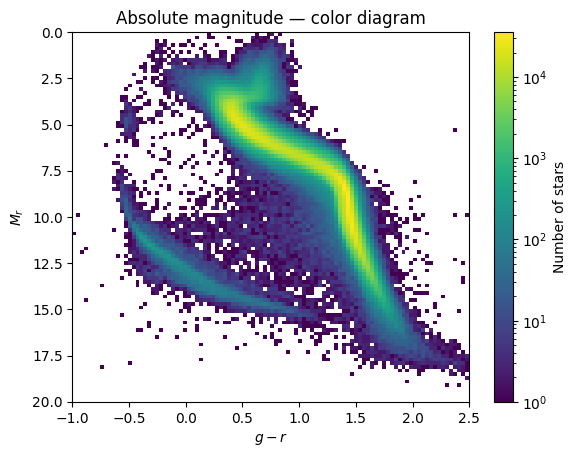
)